# Задача анализа результатов АБ-теста

**Необходимо:**

    1. Проанализировать АБ тест, проведенный на реальных пользователях Яндекса;
    2. Подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (`control`) и тестовой (`exp`) группами;
    3. Определить характер этих изменений и практическую значимость вводимого изменения;
    4. Понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение).

__Описание данных:__
* `userID`: уникальный идентификатор пользователя;
* `browser`: браузер, который использовал `userID`;
* `slot`: в каком статусе пользователь участвовал в исследовании (`exp` = видел измененную страницу, `control` = видел неизменную страницу);
* `n_clicks`: количество кликов, которые пользоваль совершил за `n_queries`;
* `n_queries`: количество запросов, который совершил `userID`, пользуясь браузером `browser`;
* `n_nonclk_queries`: количество запросов пользователя, в которых им не было совершено ни одного клика.

Не все люди используют только один браузер, поэтому в столбце `userID` есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание `userID` и `browser`.

Основная метрика в данной задаче, —  количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

In [1]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot

import numpy as np
import pandas as pd
import seaborn as sns

import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("ab_browser_test.csv", header=0) 

In [3]:
data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


**1. Посчитаем, насколько в группе `exp` больше пользовательских кликов по сравнению с группой `control` в процентах от числа кликов в контрольной группе.**

In [134]:
(np.sum(data[data['slot'] == 'exp']['n_clicks']) - np.sum(data[data['slot'] == 'control']['n_clicks'])) / \
np.sum(data[data['slot'] == 'control']['n_clicks'])*100

1.6135689824415809

Видно, что разница между количеством пользовательских кликов отличается на 1.6%.

**2. Проведем более детальный анализ разницы между двумя группами (control и exp) относительно количества пользовательских кликов.**

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

**Проверка гипотезы о равенстве медианных и средних значений количества кликов в тестовой и контрольной выборках.**

$H_0$: $med_{slot=exp}=med_{slot=control}$

$H_1$: $med_{slot=exp}\neq med_{slot=control}$

$H_0$: $mean_{slot=exp}=mean_{slot=control}$

$H_1$: $mean_{slot=exp}\neq mean_{slot=control}$

**Применим интервальную оценку статистик для каждой из двух выборок**

In [19]:
# Bootstrap

def get_bootstrap_samples(data, n_samples):
    
    """Возвращает заданное количество подвыборок n_samples сгенерированных на основе генеральной выборки data"""
    
    # Генерируется n_samples наборов индексов из доступного (исходного) диапазона. 
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    
    # Набор индексов применяется к исходным данным для получения непосредственных подвыборок.
    samples = data[indices]
    
    return samples


def stat_intervals(stat, alpha):
    """Возвращает границы доверительного интервала по значению статистики stat и уровня значимости alpha"""
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

In [21]:
data_0 = data[data['slot'] == 'exp']['n_clicks'].values
data_1 = data[data['slot'] == 'control']['n_clicks'].values

In [23]:
# В качестве статистики используется медиана (np.median)
np.random.seed(0)

# Получение списков статистик (медиан)
# Количество подвыборок задается одинаковым не смотря на разницу в объемах данных для различных групп
data_0_median_scores = list(map(np.median, get_bootstrap_samples(data_0, 1000)))
data_1_median_scores = list(map(np.median, get_bootstrap_samples(data_1, 1000)))

# По набору статистик строится 95%-ый доверительный интервал статистики
print("95% confidence interval for data_0:",  stat_intervals(data_0_median_scores, 0.05))
print("95% confidence interval for data_1:",  stat_intervals(data_1_median_scores, 0.05))

95% confidence interval for data_0: [5. 5.]
95% confidence interval for data_1: [4. 4.]


По доверительным интервалам на медианы видно, что медианное значение количества кликов в тестовой выборке выше, чем медианное значение количества кликов в контрольной выборке.

In [25]:
# В качестве статистики используется среднее (np.mean)
np.random.seed(0)

# Получение списков статистик (средних)
# Количество подвыборок задается одинаковым не смотря на разницу в объемах данных для различных групп
data_0_mean_scores = list(map(np.mean, get_bootstrap_samples(data_0, 1000)))
data_1_mean_scores = list(map(np.mean, get_bootstrap_samples(data_1, 1000)))

# По набору статистик строится 95%-ый доверительный интервал статистики
print("95% confidence interval for data_0:",  stat_intervals(data_0_mean_scores, 0.05))
print("95% confidence interval for data_1:",  stat_intervals(data_1_mean_scores, 0.05))

95% confidence interval for data_0: [11.5086867  11.66089388]
95% confidence interval for data_1: [11.20795095 11.35742732]


По доверительным интервалам на средние видно, что среднее значение количества кликов в тестовой выборке выше, чем среднее значение количества кликов в контрольной выборке.

**Для получения более точных данных применим интервальную оценку разности статистик двух выборок**

In [26]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(data_0_median_scores, data_1_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [1. 1.]


По доверительному интервалу на разность медиан видно, что медианное значение количества кликов в тестовой выборке выше, чем медианное значение количества кликов в контрольной выборке на величину в диапазоне [1. 1.]. 

In [27]:
delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(data_0_mean_scores, data_1_mean_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [0.19172563 0.40475697]


По доверительному интервалу на разность средних видно, что среднее значение количества кликов в тестовой выборке выше, чем среднее значение количества кликов в контрольной выборке на величину в диапазоне [0.19172563 0.40475697]. 

* 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо
* 95% доверительный интервал для разности средних не содержит ноль, средние отличаются статистически значимо

**3. Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Проверим последнее утверждение.**

Одновыборочный t-критерий Стьюдента. 

Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* $\bar{X}$ — среднее значение в выборке — было распределено нормально $N(μ,\frac{σ_2}{n})$
* $\frac{n}{σ_2}S_2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c $n−1$ степенями свободы $χ2(n−1)$

Проверим эти предположения с помощью бутстрепа. Ограничимся контрольной группой, в которой распределение кликов будем называть данными.

**Пояснения**

В исходной постановке t-критерий требует нормальности распределения $X_i$. Именно из-за этого предположения мы имеем, что $\sum_i X_i \sim \mathcal{N}(n \mu, n\sigma^2 )$ в силу линейности матожидания, независимости всех $X_i$ между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что $\frac{1}{n} \sum_i X_i - \mu ~\sim~ \mathcal{N}(0, \frac{\sigma^2}{n} )$

Следующие распределения эквивалентны $\mathcal{N} (0, \frac{\sigma^2}{n}) \sim \sqrt{\frac{\sigma^2}{n}} \mathcal{N}(0, 1)$

То есть другими словами мы получили, что исходная статистика $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$ распределена как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2n} { n \sigma^2} } } ~\sim~ \frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2} { \sigma^2} } }$

Распределение Стьюдента с $n-1$ степенями свободы определяется как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \chi^2 / (n-1) } } $.

Можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно $X_i$ были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

In [66]:
np.random.seed(0)
n_boot_samples = 500
n = data_1.shape[0]

# Получим из данных `n_boot_samples` псевдовыборок
data_1_mean_scores = list(map(np.mean, get_bootstrap_samples(data_1, n_boot_samples)))

# По каждой из этих выборок посчитаем среднее и сумму квадратов отклонения 
# от выборочного среднего (`control_boot_chi_squared`)
control_boot_chi_squared = list(map(lambda x: np.std(x, ddof=1), get_bootstrap_samples(data_1, n_boot_samples)))

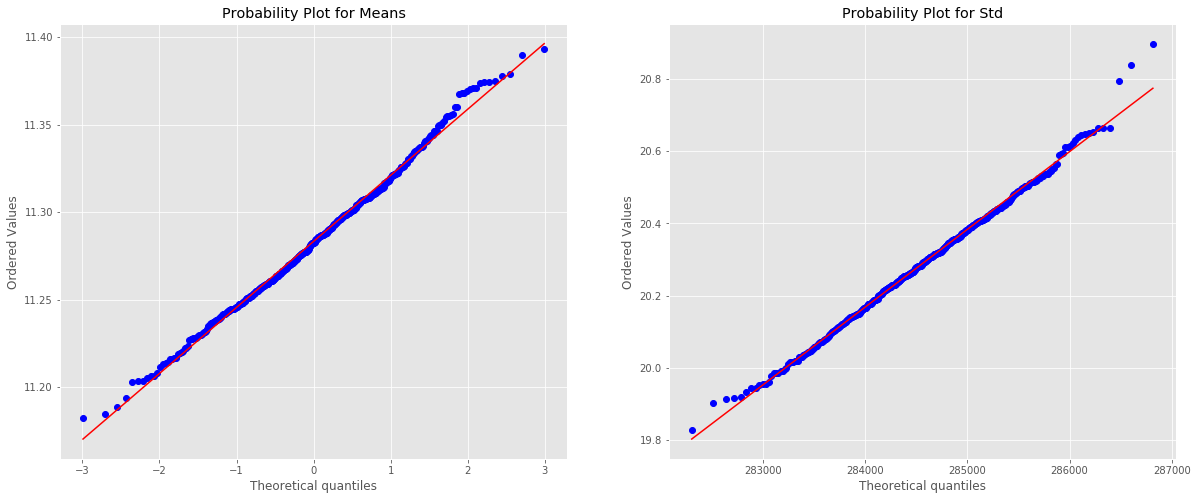

R squared for Mean 0.9979748364604207
R squared for STD 0.9979436641702913


In [67]:
# Для получившегося вектора средних значений из `n_boot_samples` 
# построим q-q plot для нормального распределения

# Для получившегося вектора сумм квадратов отклонения от выборочного среднего 
# построим qq-plot для хи-квадрат распределения 

# Q-Q графики
fig, axes = pyplot.subplots(1, 2, figsize=(20, 8))

pyplot.subplot(1,2,1)
_, R_mean = scipy.stats.probplot(data_1_mean_scores, dist="norm", plot=pyplot)
pyplot.title('Probability Plot for Means')

pyplot.subplot(1, 2, 2)
_, R_std = scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=pyplot)
# sparams=(n-1) - число степеней свободы
pyplot.title('Probability Plot for Std')

pyplot.show()

print(f'R squared for Mean {R_mean[2]}')
print(f'R squared for STD {R_std[2]}')

**4. Проверим гипотезу о равенстве средних с помощью критерия Манна-Уитни.**

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделим выборку на две части, соответствующие `control` и `exp` группам, преобразуем данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов.

In [100]:
data_0 = pd.crosstab(index=data[data['slot'] == 'exp']['userID'], 
                     columns=data[data['slot'] == 'exp']['browser'],
                     values=data[data['slot'] == 'exp']['n_clicks'],
                     aggfunc=np.sum,
                     margins=True, 
                     margins_name='СУММАРНО').iloc[:-1,-1].values

data_1 = pd.crosstab(index=data[data['slot'] == 'control']['userID'], 
                     columns=data[data['slot'] == 'control']['browser'],
                     values=data[data['slot'] == 'control']['n_clicks'],
                     aggfunc=np.sum,
                     margins=True, 
                     margins_name='СУММАРНО').iloc[:-1,-1].values

**Ранговый критерий Манна-Уитни**

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [102]:
from scipy import stats

In [103]:
stats.mannwhitneyu(data_0, data_1)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

p-value меньше 0.05, что позволяет отвергнуть нулевую гипотезу. Распределения данных отличаются.

**Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками**

**5. Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.**

Применим для каждого из срезов (по каждому из уникальных значений столбца `browser`) критерий Манна-Уитни между `control` и `exp` группами и сделаем поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

In [119]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [114]:
mannwhitneyu_data = []
for browser in set(data['browser']):
    data_0 = data[(data['slot'] == 'exp') & (data['browser'] == browser)]['n_clicks']
    data_1 = data[(data['slot'] == 'control') & (data['browser'] == browser)]['n_clicks']
    statistic, pvalue = stats.mannwhitneyu(data_0, data_1)
    mannwhitneyu_data.append([browser, statistic, pvalue])

mannwhitneyu_data = pd.DataFrame.from_records(mannwhitneyu_data)
mannwhitneyu_data.columns = ['browser', 'statistic', 'pvalue']

In [122]:
reject, p_corrected, a1, a2 = multipletests(mannwhitneyu_data['pvalue'], 
                                            alpha = 0.05/2, 
                                            method = 'holm')

mannwhitneyu_data['p_corrected'] = p_corrected
mannwhitneyu_data['reject'] = reject

In [123]:
mannwhitneyu_data

,browser,statistic,pvalue,p_corrected,reject
0,Browser #20,1.437918e+08,0.453667,0.815212,False
1,Browser #4,3.072448e+09,0.407606,0.815212,False
2,Browser #22,2.547598e+09,0.257406,0.772217,False
3,Browser #17,1.313897e+08,0.037401,0.149602,False
4,Browser #2,1.522573e+09,0.027244,0.136219,False
5,Browser #14,8.069847e+08,0.000000,0.000000,True


Нулевая гипотеза для `Browser #14` отвергается. Следовательно, **для данного браузера разница между распределением кликов в тестовой и контрольной выборках является статистически значимой.**

**6. Для каждого браузера в каждой из двух групп (`control` и `exp`) посчитаем долю запросов, в которых пользователь не кликнул ни разу.**

Для этого поделим сумму значений n_nonclk_queries на сумму значений n_queries. 

In [130]:
np.sum(data[(data['slot'] == 'exp') & (data['browser'] == browser)]['n_nonclk_queries']) / \
np.sum(data[(data['slot'] == 'exp') & (data['browser'] == browser)]['n_queries'])

0.4375561736127329

In [131]:
clicks_statistics = []
for browser in set(data['browser']):
    p_nonclk_exp = np.sum(data[(data['slot'] == 'exp') & (data['browser'] == browser)]['n_nonclk_queries']) / \
    np.sum(data[(data['slot'] == 'exp') & (data['browser'] == browser)]['n_queries'])
    
    p_nonclk_control = np.sum(data[(data['slot'] == 'control') & (data['browser'] == browser)]['n_nonclk_queries']) / \
    np.sum(data[(data['slot'] == 'control') & (data['browser'] == browser)]['n_queries'])

    clicks_statistics.append([browser, p_nonclk_exp, p_nonclk_control])
    
clicks_statistics = pd.DataFrame.from_records(clicks_statistics)
clicks_statistics.columns = ['browser', 'p_nonclk_exp', 'p_nonclk_control']

In [132]:
clicks_statistics

,browser,p_nonclk_exp,p_nonclk_control
0,Browser #20,0.389774,0.405405
1,Browser #4,0.451429,0.469709
2,Browser #22,0.398539,0.405940
3,Browser #17,0.369374,0.362994
4,Browser #2,0.449827,0.459627
5,Browser #14,0.437556,0.575904


Из таблицы видно, что доля некликов для браузера `Browser #14` значительно отличается между тестовой и контрольной группой.

**С помощью анализа, проведенного выше, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.**